<table style="width: 100%;">
    <tr style="background-color: transparent;"><td>
        <img src="https://data-88e.github.io/assets/images/blue_text.png" width="250px" style="margin-left: 0;" />
    </td><td>
        <p style="text-align: right; font-size: 10pt;"><strong>Economic Models</strong>, Fall 2022<br>
            Dr. Eric Van Dusen <br>
        Amal Bhatnagar</p></td></tr>
</table>

# Using Data Science to Determine Whether to Open a Boba Store 

In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import pytz
import numpy as np
import matplotlib.pyplot as plt

  You are the owner of a boba shop in LA called "Delicious Boba". Your store is very successful in LA. There's always a line out of the door, customers leave great reviews, and your employees are happy. Given all of the recent successes, you want to expand into new markets and open another store in Berkeley, CA. 

Because you are new to the Berkeley area, you want to understand if you should open a store in Berkeley, and if so, then where. Specifically, you want to answer:
#### "Should I open a `Delicious Boba` store in Berkeley?"

To answer this question, you turn to using data from PredictHQ. 

PredictHQ provides real-time event data to companies like Uber and airlines for their dynamic pricing algorithms. It can help give insight on the Berkeley market's foot traffic, even if you're not there. 

To access data from third party data providers, you usually have to register for an API Access Code. This helps the data provider understand:
1. Who is accessing their data?
2. How frequently is the user accessing their data?
3. How much data is the user accessing?

This information helps the data provider:
1. Build infrastructure to support the volume of API calls
2. Bill accordingly 

### What does Berkeley's Event Data look like?

The dataset we are working with was created using PredictHQ's free trial. We looked at all events between August 2020 to June 2022 within 5 miles of UC Berkeley's campus. 

*As a quick disclaimer, all the analysis in this notebook is done using Pandas, a more advanced data science library than the one used in this class. Please don't feel discouraged if you don't understand the code, but feel free to take data 100 for a great introduction to Pandas!*

In [4]:
berkeley_events_df = pd.read_csv("Berkeley_Events_Data.csv", index_col = 0)

In [5]:
berkeley_events_df.head()

,cancelled,category,country,deleted_reason,description,duplicate_of_id,duration,end,first_seen,geo,...,predicted_end,private,rank,entity_name,longitude,latitude,sub_category,session_type,estimated,on_campus
0,NaN,community,US,NaN,"Cost:Â $10 JCC MembersÂ â""$12 General\nÂ\nBod...",NaN,0,2020-11-30 17:15:00+00:00,2020-10-16 03:27:25+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,17,JCC East Bay - Jewish Community Center of the ...,-122.268514,37.881531,NaN,in-person,not_estimated,True
1,NaN,observances,US,NaN,The UN’s Day of Remembrance for all Victims of...,NaN,86399,2020-11-30 23:59:59+00:00,2017-01-04 22:59:13+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,50,Day of Remembrance for all Victims of Chemical...,-95.712891,37.090240,holiday,in-person,not_estimated,False
2,NaN,observances,US,NaN,Most online retailers in the US offer discount...,NaN,86399,2020-11-30 23:59:59+00:00,2017-01-04 23:06:06+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,50,Cyber Monday,-95.712891,37.090240,holiday,in-person,not_estimated,False
3,NaN,sports,US,NaN,NaN,NaN,0,2020-11-29 22:00:00+00:00,2020-12-01 01:46:03+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,2020-11-29 23:35:00+00:00,False,40,Walter A. Haas Jr. Pavilion,-122.262310,37.869388,NaN,in-person,not_estimated,True
4,NaN,observances,US,NaN,Many Christians in the United States observe t...,NaN,86399,2020-11-29 23:59:59+00:00,2017-01-04 23:06:02+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,50,First Sunday of Advent,-95.712891,37.090240,holiday,in-person,not_estimated,False


We want our Boba shop to have various sources of traffic. The `category` column seems interesting. Let's see what types of categories we have data for.

In [6]:
list(set(berkeley_events_df['category']))

['observances',
 'festivals',
 'community',
 'politics',
 'performing-arts',
 'concerts',
 'public-holidays',
 'daylight-savings',
 'school-holidays',
 'severe-weather',
 'terror',
 'academic',
 'expos',
 'conferences',
 'disasters',
 'sports']

Which events are most popular?

In [9]:
berkeley_events_df.groupby(["entity_name", 'category']).count().sort_values(by = 'phq_attendance', ascending = False).head(10)

,,cancelled,country,deleted_reason,description,duplicate_of_id,duration,end,first_seen,geo,id,...,phq_attendance,predicted_end,private,rank,longitude,latitude,sub_category,session_type,estimated,on_campus
entity_name,category,,,,,,,,,,,,,,,,,,,,,
The New Parish,concerts,0,168,0,3,0,168,168,168,168,168,...,168,0,168,168,168,168,0,168,168,168
Ivy Room,concerts,0,105,0,0,0,105,105,105,105,105,...,105,0,105,105,105,105,0,105,105,105
Cornerstone - CA,concerts,0,85,0,0,0,85,85,85,85,85,...,85,0,85,85,85,85,0,85,85,85
Fox Theater,concerts,0,80,0,0,0,80,80,80,80,80,...,80,0,80,80,80,80,0,80,80,80
Cornerstone Craft Beer & Live Music,concerts,0,63,0,0,0,63,63,63,63,63,...,63,0,63,63,63,63,0,63,63,63
Walter A. Haas Jr. Pavilion,sports,0,58,0,0,0,58,58,58,58,58,...,58,55,58,58,58,58,0,58,58,58
UC Theatre,concerts,0,57,0,0,0,57,57,57,57,57,...,57,0,57,57,57,57,0,57,57,57
The Back Room,concerts,0,57,0,39,0,57,57,57,57,57,...,57,0,57,57,57,57,0,57,57,57
Starline Social Club,concerts,0,54,0,0,0,54,54,54,54,54,...,54,0,54,54,54,54,0,54,54,54


Let's take a look at `concerts`

In [12]:
concerts_df = berkeley_events_df[berkeley_events_df['category'] == 'concerts'].reset_index(drop = True)
concerts_df.head(3)

,cancelled,category,country,deleted_reason,description,duplicate_of_id,duration,end,first_seen,geo,...,predicted_end,private,rank,entity_name,longitude,latitude,sub_category,session_type,estimated,on_campus
0,NaN,concerts,US,NaN,NaN,NaN,0,2021-03-30 02:00:00+00:00,2021-03-06 20:13:24+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,9,Soundwave Studios,-122.292864,37.818850,NaN,in-person,not_estimated,True
1,NaN,concerts,US,NaN,NaN,NaN,0,2021-03-26 00:00:00+00:00,2021-03-21 08:02:04+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,12,Piedmont Piano,-122.272029,37.807665,NaN,in-person,not_estimated,True
2,NaN,concerts,US,NaN,Masters of Hawaiian Music: George Kahumoku Jr....,NaN,0,2021-03-22 02:00:00+00:00,2021-01-23 05:48:39+00:00,"{'geometry': {'type': 'Point', 'coordinates': ...",...,NaN,False,0,NaN,-122.269582,37.870737,NaN,in-person,not_estimated,True


In [11]:
concerts_df.shape

(1097, 39)

How big is our dataset?
- 1097 observations -- This is great
- 39 columns -- We might want to narrow the columns

This means that we have information on ~1,100 concerts and 39 features over a 2 year span

In [ ]:
(list(concerts_df.columns))

['cancelled',
 'category',
 'country',
 'deleted_reason',
 'description',
 'duplicate_of_id',
 'duration',
 'end',
 'first_seen',
 'geo',
 'id',
 'impact_patterns',
 'labels',
 'location',
 'parent_event',
 'place_hierarchies',
 'postponed',
 'relevance',
 'scope',
 'start',
 'state',
 'timezone',
 'title',
 'updated',
 'aviation_rank',
 'brand_safe',
 'entities',
 'local_rank',
 'phq_attendance',
 'predicted_end',
 'private',
 'rank',
 'entity_name',
 'longitude',
 'latitude',
 'sub_category',
 'session_type',
 'estimated',
 'on_campus']

In [13]:
columns_to_filter = ['category','description','duration', 'end', 'first_seen', 'id',
       'labels', 'start','title', 'updated', 'aviation_rank', 'brand_safe',
       'entities', 'local_rank', 'phq_attendance',  
       'rank', 'entity_name', 'longitude', 'latitude',
       'session_type', 'estimated', 'on_campus']

In [14]:
concerts_df_filtered = concerts_df[columns_to_filter]

What are some key columns?
- `entity_name` - Organization Name
- `phq_attendance` - Number of people PredictHQ estimates who attended the event on that day
- `start` - Observation's start time
- `end` - Observation's end time

In [17]:
concerts_df_filtered.head(5)

,category,description,duration,end,first_seen,id,labels,start,title,updated,...,entities,local_rank,phq_attendance,rank,entity_name,longitude,latitude,session_type,estimated,on_campus
0,concerts,NaN,0,2021-03-30 02:00:00+00:00,2021-03-06 20:13:24+00:00,j9FZA4KpcLgfiVFZHt,"['concert', 'music']",2021-03-30 02:00:00+00:00,Good.To.Go and Reggie Rare,2022-04-12 22:11:05+00:00,...,"[{'entity_id': 'aftjs5Ccvyvnd3uYguBJFB', 'name...",25.0,9.0,9,Soundwave Studios,-122.292864,37.818850,in-person,not_estimated,True
1,concerts,NaN,0,2021-03-26 00:00:00+00:00,2021-03-21 08:02:04+00:00,beCasLXtNSCoAdKGLD,"['concert', 'music']",2021-03-26 00:00:00+00:00,The Bobby Young Project,2021-03-21 08:07:33+00:00,...,"[{'entity_id': 'gVKnKDvjq8n7eYFvhy4XEc', 'name...",24.0,12.0,12,Piedmont Piano,-122.272029,37.807665,in-person,not_estimated,True
2,concerts,Masters of Hawaiian Music: George Kahumoku Jr....,0,2021-03-22 02:00:00+00:00,2021-01-23 05:48:39+00:00,6BHVTKHp7GQJVNPUh6,"['concert', 'music']",2021-03-22 02:00:00+00:00,Masters of Hawaiian Music,2021-01-23 05:49:47+00:00,...,[],0.0,0.0,0,NaN,-122.269582,37.870737,in-person,not_estimated,True
3,concerts,Altan,0,2021-03-21 03:00:00+00:00,2021-01-22 23:56:38+00:00,f2Quk8SazCARdvzXL6,"['concert', 'music']",2021-03-21 03:00:00+00:00,Altan (3/20/21),2021-01-23 00:19:41+00:00,...,[],0.0,0.0,0,NaN,-122.269582,37.870737,in-person,not_estimated,True
4,concerts,NaN,0,2021-03-21 01:30:00+00:00,2021-04-22 04:34:46+00:00,PJgWyJRnzfuXnVjTf9,"['concert', 'music']",2021-03-21 01:30:00+00:00,Brother Spellbinder,2021-04-22 05:59:04+00:00,...,"[{'entity_id': 'yFTuXgPy3ynS3nJeHmcH7B', 'name...",19.0,6.0,6,Art House Gallery and Cultural Center,-122.266362,37.856435,in-person,not_estimated,True


Let's see a list of organizations 

In [18]:
list(set(concerts_df_filtered['entity_name']))

[nan,
 'UC Berkeley',
 'Soundwave Studios',
 'The Sound Room',
 'Stork Club',
 'Bay Street',
 'Donkey & Goat Winery',
 'Lake Merritt Plaza',
 'Tamarack',
 'Piedmont Center for the Arts',
 'First Congregational Church of Berkeley',
 'Crybaby',
 'The UC Theatre Taube Family Music Hall',
 'Gather',
 'Paramount Theatre',
 'The Washington Inn Hotel',
 'Starline Social Club Ballroom',
 'Zellerbach Auditorium',
 'Empress Vintage',
 'The 924 Gilman Street Project',
 'Continental Comedy Club',
 'Bandcamp',
 'Joyce Gordon Gallery',
 'California Jazz Conservatory',
 'The Golden Bull Bar',
 'New Karibbean City',
 'Cornerstone - CA',
 'Piedmont Piano',
 'Medicine Ball Party Concert',
 'The New Parish',
 'Venue Oakland',
 'White Horse Inn',
 'University of California, Berkeley',
 'Little Hill Lounge',
 'Freight & Salvage Coffeehouse',
 "St Alban's Episcopal Church",
 'Cafe Van Kleef',
 'Albany Bulb',
 'Horn Barbecue',
 'East Bay Community Space',
 'Ashby Arts Space',
 'Crowden Music Center',
 'The J

Here are three quick observations of our data:
1. There are many concert venues in Berkeley
2. The Entity Names are listed in different formats
      - ELI'S MILE HIGH CLUB
      - cafe leila - Berkeley CA
      - Study Hall (rooftop of Residence Inn)
      - The New Parish
3. Some veneues are documented several times in different ways
      - Cornerstone
      - Cornerstone Craft Beer & Live Music
      - Cornerstone - CA


#### The Entity Names are listed in different formats
- ELI'S MILE HIGH CLUB
- cafe leila - Berkeley CA
- Study Hall (rooftop of Residence Inn)
- The New Parish

Why may this be?
- PredictHQ may be scraping and collecting its data from other sites. Each data source they collect from may have different naming conventions. 
- This also explains why the same venue may be listed as different ways (next section)
- This also explains why some entity names are generic while others are more specific
  - UC Berkeley vs Zellerbach Auditorium

#### Some veneues are documented several times in different ways
What are some implications of this data problem?
- May miss out on a venue's data because it was listed as a different way

Let's take `Cornerstone` as an example. How do we know all the ways a venue can be listed as in this dataset?
- Look at all instances `Cornerstone` is mentioned in any Entity Name
- Lowercase `Cornerstone` so capitalization does not affect the search results

In [21]:
len([x for x in concerts_df_filtered['entity_name'] if 'cornerstone' in str(x).lower()])

149

Not every observation has an Entity Name. Some rows have missing data. 

In general, how can we fix missing data?
- Fill with average
- Fill with 0
- Remove from the dataset

In this case, because the data is string, we can replace missing entries with an empty string

In [22]:
concerts_df_filtered = concerts_df_filtered.fillna("")

In [23]:
list(set([x for x in concerts_df_filtered['entity_name'] if 'cornerstone' in x.lower()]))

['Cornerstone', 'Cornerstone - CA', 'Cornerstone Craft Beer & Live Music']

In [24]:
cornerstone_string_entries = ['Cornerstone Craft Beer & Live Music', 'Cornerstone - CA', 'Cornerstone']

In [25]:
cornerstone_df = concerts_df_filtered[concerts_df_filtered['entity_name'].isin(cornerstone_string_entries)].reset_index(drop = True)

In [27]:
cornerstone_df.head(5)

,category,description,duration,end,first_seen,id,labels,start,title,updated,...,entities,local_rank,phq_attendance,rank,entity_name,longitude,latitude,session_type,estimated,on_campus
0,concerts,,0,2021-07-26 03:00:00+00:00,2021-06-17 02:40:54+00:00,YnbTXQ5jrroWiPdZmH,"['concert', 'music']",2021-07-26 03:00:00+00:00,Sub-Radio,2022-07-30 01:16:11+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",50.0,303.0,40,Cornerstone - CA,-122.267323,37.86632,in-person,not_estimated,True
1,concerts,,0,2021-07-17 15:30:00+00:00,2021-07-10 14:19:27+00:00,xm7j8KW9YDo7WQShqA,"['concert', 'music']",2021-07-17 15:30:00+00:00,"Mili Perez, Bosslife Big Spence, Stunnaman02, ...",2022-07-30 01:15:37+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",56.0,566.0,45,Cornerstone - CA,-122.267323,37.86632,in-person,not_estimated,True
2,concerts,,0,2021-06-25 02:30:00+00:00,2021-06-17 20:16:04+00:00,xCex9n3p8Mvvqe8kx5,"['concert', 'music']",2021-06-25 02:30:00+00:00,"Van Goat, Red Elvises, and Igor & the Red Elvises",2022-07-30 01:16:03+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",53.0,402.0,42,Cornerstone - CA,-122.267323,37.86632,in-person,not_estimated,True
3,concerts,,0,2021-06-21 02:00:00+00:00,2021-05-26 20:18:18+00:00,wJNipsxyvc3HCY25Cw,"['concert', 'music']",2021-06-21 02:00:00+00:00,Leslie Mendelson,2022-09-10 06:15:09+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",54.0,443.0,43,Cornerstone - CA,-122.267323,37.86632,in-person,not_estimated,True
4,concerts,,0,2021-05-27 01:00:00+00:00,2021-05-25 21:19:51+00:00,vAD8YQRDdCX6JnXGSN,"['concert', 'music']",2021-05-27 01:00:00+00:00,"The Happy Fits, M.A.G.S., and Snarls",2022-08-10 01:15:48+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",45.0,161.0,34,Cornerstone - CA,-122.267323,37.86632,in-person,not_estimated,True


In [28]:
cornerstone_df.sort_values(by = 'start', ascending = True)

,category,description,duration,end,first_seen,id,labels,start,title,updated,...,entities,local_rank,phq_attendance,rank,entity_name,longitude,latitude,session_type,estimated,on_campus
5,concerts,,0,2021-04-30 03:30:00+00:00,2020-08-28 05:37:21+00:00,kb2yfuyhGP7scThiyy,"['concert', 'music']",2021-04-30 03:30:00+00:00,Tech N9ne,2022-07-30 01:16:15+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",43.0,136.0,33,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
4,concerts,,0,2021-05-27 01:00:00+00:00,2021-05-25 21:19:51+00:00,vAD8YQRDdCX6JnXGSN,"['concert', 'music']",2021-05-27 01:00:00+00:00,"The Happy Fits, M.A.G.S., and Snarls",2022-08-10 01:15:48+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",45.0,161.0,34,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
3,concerts,,0,2021-06-21 02:00:00+00:00,2021-05-26 20:18:18+00:00,wJNipsxyvc3HCY25Cw,"['concert', 'music']",2021-06-21 02:00:00+00:00,Leslie Mendelson,2022-09-10 06:15:09+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",54.0,443.0,43,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
2,concerts,,0,2021-06-25 02:30:00+00:00,2021-06-17 20:16:04+00:00,xCex9n3p8Mvvqe8kx5,"['concert', 'music']",2021-06-25 02:30:00+00:00,"Van Goat, Red Elvises, and Igor & the Red Elvises",2022-07-30 01:16:03+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",53.0,402.0,42,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
1,concerts,,0,2021-07-17 15:30:00+00:00,2021-07-10 14:19:27+00:00,xm7j8KW9YDo7WQShqA,"['concert', 'music']",2021-07-17 15:30:00+00:00,"Mili Perez, Bosslife Big Spence, Stunnaman02, ...",2022-07-30 01:15:37+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",56.0,566.0,45,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,concerts,,0,2022-05-22 01:00:00+00:00,2022-03-25 20:18:02+00:00,8PdNwRtghXL9fLRK4N,"['concert', 'music']",2022-05-22 01:00:00+00:00,mewithoutYou,2022-07-30 01:15:36+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",55.0,516.0,44,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
119,concerts,,0,2022-05-23 03:00:00+00:00,2022-02-08 20:13:11+00:00,5CXkfG7D6ZdwLsgXc8,"['concert', 'music']",2022-05-23 03:00:00+00:00,Girl Ultra and Jasper Bones,2022-08-19 20:22:13+00:00,...,"[{'entity_id': 'CiNnihybTKR79McUAPLQwP', 'name...",51.0,349.0,41,Cornerstone Craft Beer & Live Music,-122.267195,37.866349,in-person,not_estimated,True
118,concerts,,0,2022-05-28 02:00:00+00:00,2022-02-03 20:12:02+00:00,9LezoKaRmoTdHVizrb,"['concert', 'music']",2022-05-28 02:00:00+00:00,Rivers Of Nihil,2022-07-30 01:16:21+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",56.0,556.0,45,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True
117,concerts,,0,2022-05-29 03:00:00+00:00,2022-04-19 20:16:33+00:00,CVfMpJ3CKexuyFQjJW,"['concert', 'music']",2022-05-29 03:00:00+00:00,Ravyn Lenae,2022-07-30 01:15:49+00:00,...,"[{'entity_id': 'XyG5k9E5jPMhZuzjZk6PdM', 'name...",58.0,732.0,47,Cornerstone - CA,-122.267323,37.866320,in-person,not_estimated,True


When I first gathered data from PredictHQ, I looked for events from August 2020 to June 2022. The earliest concert at Cornerstone during that timeframe is for April 30th 2021. 

Why is that?
- Concerts were likely cancelled before that due to COVID

2 questions we can answer with data:
1. How many concerts happen at Cornerstone per month? 
2. How many people come to these concerts? 

#### How many concerts happen at Cornerstone per month?

In [29]:
start_datetime = [datetime.strptime(x.split()[0], '%Y-%m-%d') for x in cornerstone_df['start']]

In [30]:
cornerstone_df['start_datetime'] = start_datetime

In [31]:
cornerstone_df['year'] = pd.DatetimeIndex(cornerstone_df['start_datetime']).year
cornerstone_df['month'] = pd.DatetimeIndex(cornerstone_df['start_datetime']).month

In [32]:
cornerstone_concerts_per_month = cornerstone_df.groupby(['year', 'month']).count().reset_index()[['year', 'month', 'category']].rename(columns = {"category" : "number_concerts"})

In [33]:
cornerstone_concerts_per_month_year_string = [str(x) for x in cornerstone_concerts_per_month['year']]
cornerstone_concerts_per_month_month_string = [str(x) for x in cornerstone_concerts_per_month['month']]
new_dates = []
for i in range(len(cornerstone_concerts_per_month_year_string)):
  new_year = cornerstone_concerts_per_month_year_string[i]
  new_month = cornerstone_concerts_per_month_month_string[i]
  new_date = new_year + ' - ' + new_month
  new_dates.append(new_date)
cornerstone_concerts_per_month['New Date'] = new_dates

In [34]:
cornerstone_concerts_per_month.head(10)

,year,month,number_concerts,New Date
0,2021,4,1,2021 - 4
1,2021,5,1,2021 - 5
2,2021,6,2,2021 - 6
3,2021,7,2,2021 - 7
4,2021,8,10,2021 - 8
5,2021,9,11,2021 - 9
6,2021,10,15,2021 - 10
7,2021,11,18,2021 - 11
8,2021,12,15,2021 - 12
9,2022,1,8,2022 - 1


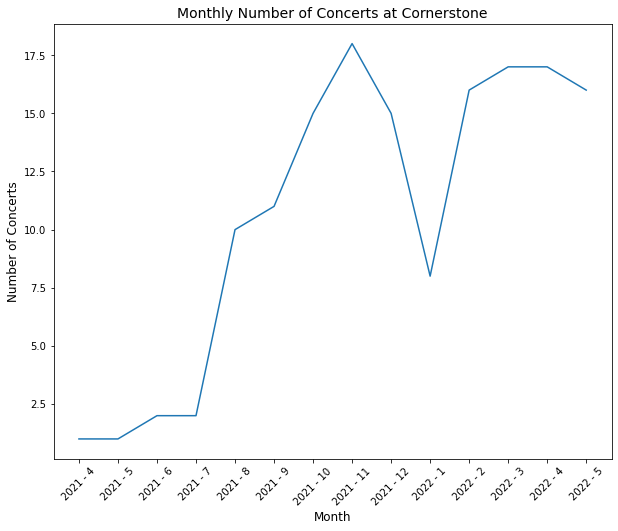

In [36]:
plt.figure(figsize = (10, 8))
plt.plot(cornerstone_concerts_per_month['New Date'], cornerstone_concerts_per_month['number_concerts'])
plt.xticks(rotation = 45)
plt.title("Monthly Number of Concerts at Cornerstone", size = 14)
plt.xlabel("Month", size = 12)
plt.ylabel("Number of Concerts", size = 12);

Ever since concerts resumed after COVID, Cornerstone has held about 15 concerts a month.

### How many people come to these concerts?

In [37]:
cornerstone_concert_attendance_per_month = cornerstone_df.groupby(['year', 'month']).mean().reset_index()[['year', 'month', 'phq_attendance']]

In [38]:
cornerstone_concert_attendance_per_month_year_string = [str(x) for x in cornerstone_concert_attendance_per_month['year']]
cornerstone_concert_attendance_per_month_month_string = [str(x) for x in cornerstone_concert_attendance_per_month['month']]
new_dates = []
for i in range(len(cornerstone_concert_attendance_per_month_year_string)):
  new_year = cornerstone_concert_attendance_per_month_year_string[i]
  new_month = cornerstone_concert_attendance_per_month_month_string[i]
  new_date = new_year + ' - ' + new_month
  new_dates.append(new_date)
cornerstone_concert_attendance_per_month['New Date'] = new_dates
cornerstone_concert_attendance_per_month

,year,month,phq_attendance,New Date
0,2021,4,136.000000,2021 - 4
1,2021,5,161.000000,2021 - 5
2,2021,6,422.500000,2021 - 6
3,2021,7,434.500000,2021 - 7
4,2021,8,385.000000,2021 - 8
5,2021,9,521.454545,2021 - 9
6,2021,10,418.600000,2021 - 10
7,2021,11,368.777778,2021 - 11
8,2021,12,458.466667,2021 - 12
9,2022,1,397.375000,2022 - 1


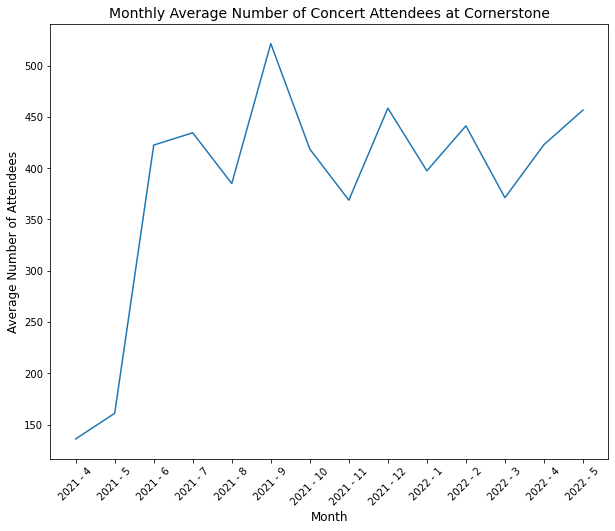

In [39]:
plt.figure(figsize = (10, 8))
plt.plot(cornerstone_concert_attendance_per_month['New Date'], cornerstone_concert_attendance_per_month['phq_attendance'])
plt.xticks(rotation = 45)
plt.title("Monthly Average Number of Concert Attendees at Cornerstone", size = 14)
plt.xlabel("Month", size = 12)
plt.ylabel("Average Number of Attendees", size = 12);

On average, between 400 and 450 people attend each concert

# Concerts 

We looked at attendance patterns from only Cornerstone's concerts. 

Can we expect similar traffic from other concerts?


In [40]:
concerts_df['start_datetime'] = [datetime.strptime(x.split()[0], '%Y-%m-%d') for x in concerts_df['start']]
concerts_df['year'] = pd.DatetimeIndex(concerts_df['start_datetime']).year
concerts_df['month'] = pd.DatetimeIndex(concerts_df['start_datetime']).month

concerts_year = list(concerts_df['year'])
concerts_month = list(concerts_df['month'])

In [41]:
concerts_df = concerts_df.sort_values(by = ['year', 'month'])

In [67]:
average_concert_attendance_per_month = concerts_df.groupby(['year', 'month']).mean().reset_index()[['year', 'month', 'phq_attendance']]
median_concert_attendance_per_month = concerts_df.groupby(['year', 'month']).median().reset_index()[['year', 'month', 'phq_attendance']]
max_concert_attendance_per_month = concerts_df.groupby(['year', 'month'])[['phq_attendance']].max().reset_index()
total_concert_attendance_per_month = concerts_df.groupby(['year', 'month']).sum().reset_index()[['year', 'month', 'phq_attendance']]


In [68]:
new_dates = []
concerts_year = average_concert_attendance_per_month['year']
concerts_month = average_concert_attendance_per_month['month']
for i in range(len(average_concert_attendance_per_month)):
  new_year = concerts_year[i]
  new_month = concerts_month[i]
  new_date = str(new_year) + ' - ' + str(new_month)
  new_dates.append(new_date)
average_concert_attendance_per_month['New Date'] = new_dates
median_concert_attendance_per_month['New Date'] = new_dates
max_concert_attendance_per_month['New Date'] = new_dates
total_concert_attendance_per_month['New Date'] = new_dates

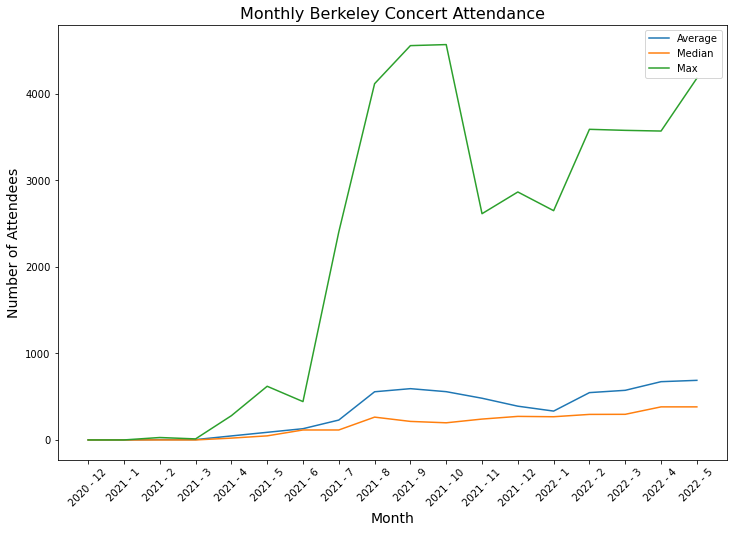

In [69]:
plt.figure(figsize = (12, 8))
plt.title("Monthly Berkeley Concert Attendance", size = 16)
plt.plot(average_concert_attendance_per_month['New Date'], average_concert_attendance_per_month['phq_attendance'], label = 'Average')
plt.plot(median_concert_attendance_per_month['New Date'], median_concert_attendance_per_month['phq_attendance'], label = 'Median')
plt.plot(max_concert_attendance_per_month['New Date'], max_concert_attendance_per_month['phq_attendance'], label = 'Max')
plt.legend()
plt.xticks(rotation = 45)
plt.xlabel("Month", size = 14)
plt.ylabel("Number of Attendees", size = 14);

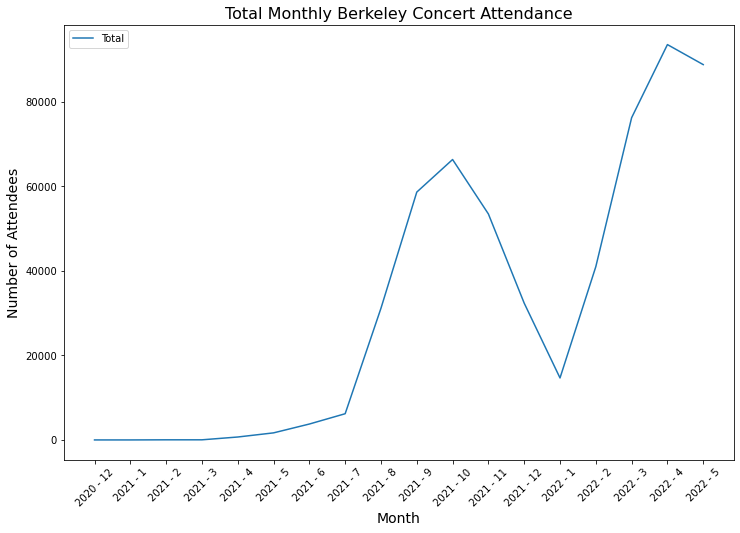

In [70]:
plt.figure(figsize = (12, 8))
plt.title("Total Monthly Berkeley Concert Attendance", size = 16)
plt.plot(total_concert_attendance_per_month['New Date'], total_concert_attendance_per_month['phq_attendance'], label = 'Total')
plt.legend()
plt.xticks(rotation = 45)
plt.xlabel("Month", size = 14)
plt.ylabel("Number of Attendees", size = 14);

Some concerts may have a smaller audience while others may have a larger one. We should always look at the median to mitigate the effect of outliers

- The average, median, and max show a lower attendance in the beginning of 2021 and higher attendance in the second half of 2021
- Tens of thousands of people attend concerts in Berkeley every month

### Education

We know that primarily UC Berkeley students live near UC Berkeley, but are there other students nearby who our Boba store can attract?

In [71]:
list(set(berkeley_events_df[berkeley_events_df['category'] == 'academic']['entity_name']))

['Paramount Theatre',
 'The Greek Theatre',
 'California Memorial Stadium',
 'Berkeley City College',
 'Walter A. Haas Jr. Pavilion',
 'Zellerbach Auditorium',
 'University of California, Berkeley']

There are two schools that immediately come to mind:
- University of California, Berkeley
- Berkeley City College

How many students can we expect from these two schools?

In [72]:
uc_berkeley_students_df = berkeley_events_df[(berkeley_events_df['entity_name'] ==  'University of California, Berkeley') & 
                   (berkeley_events_df['category'] == 'academic')].sort_values(by = 'start').reset_index(drop = True)

bcc_students_df = berkeley_events_df[(berkeley_events_df['entity_name'] ==  'Berkeley City College') & 
                   (berkeley_events_df['category'] == 'academic')].sort_values(by = 'start').reset_index(drop = True)

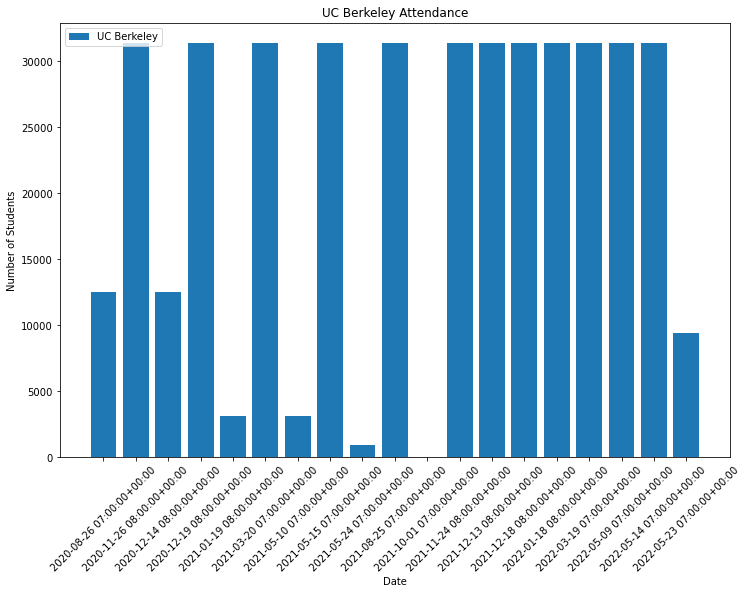

In [76]:
plt.figure(figsize = (12, 8))
plt.bar(uc_berkeley_students_df['start'], uc_berkeley_students_df['phq_attendance'], label = 'UC Berkeley')

plt.xlabel("Date")
plt.ylabel("Number of Students")
plt.title("UC Berkeley Attendance")
plt.xticks(rotation = 45)
plt.legend();

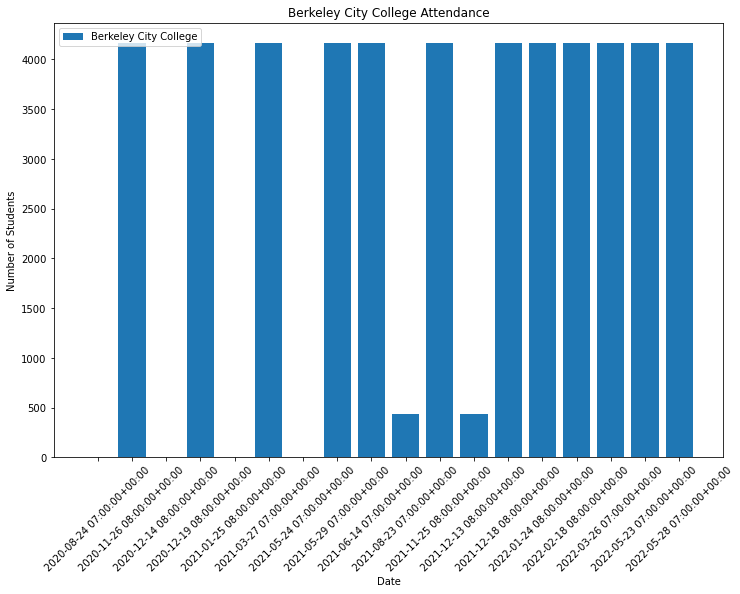

In [75]:
plt.figure(figsize = (12, 8))
plt.bar(bcc_students_df['start'], bcc_students_df['phq_attendance'], label = 'Berkeley City College')

plt.xlabel("Date")
plt.ylabel("Number of Students")
plt.title("Berkeley City College Attendance")
plt.xticks(rotation = 45)
plt.legend();

What do we notice?
- The dates are in long-form, which makes it difficult to read
- In 2021, some records show 2.5K attendance while others show 30K attendance. Why may this be?
  - Covid --> We should dig deeper on whether the attendance record is showing number of people on-campus or online for each school

In [77]:
list(set(uc_berkeley_students_df['session_type']))

['hybrid-session', 'in-person', 'online-session']

In [78]:
start_datetime = [datetime.strptime(x.split()[0], '%Y-%m-%d') for x in uc_berkeley_students_df['start']]
uc_berkeley_students_df['start_datetime'] = start_datetime
uc_berkeley_students_df['year'] = pd.DatetimeIndex(uc_berkeley_students_df['start_datetime']).year
uc_berkeley_students_df['month'] = pd.DatetimeIndex(uc_berkeley_students_df['start_datetime']).month

start_datetime = [datetime.strptime(x.split()[0], '%Y-%m-%d') for x in bcc_students_df['start']]
bcc_students_df['start_datetime'] = start_datetime
bcc_students_df['year'] = pd.DatetimeIndex(bcc_students_df['start_datetime']).year
bcc_students_df['month'] = pd.DatetimeIndex(bcc_students_df['start_datetime']).month

In [79]:
uc_berkeley_students_df.groupby(['year', 'month', 'session_type']).max().reset_index()[['year', 'month', 'session_type', 'sub_category', 'phq_attendance']]

,year,month,session_type,sub_category,phq_attendance
0,2020,8,hybrid-session,academic-session,12540.0
1,2020,11,in-person,holiday,31352.0
2,2020,12,hybrid-session,exam,12540.0
3,2020,12,in-person,holiday,31352.0
4,2021,1,online-session,academic-session,3135.0
5,2021,3,in-person,holiday,31352.0
6,2021,5,in-person,holiday,31352.0
7,2021,5,online-session,exam,3135.0
8,2021,8,in-person,academic-session,31352.0
9,2021,10,in-person,social,0.0


Some observations:
- Most events' attendance is 31352. They may have replaced all missing values with the average UC Berkeley attendance. 
- One value has 0. This may be a data error. 
- Hybrid has 12540 people attending Berkeley for both entries. They may have replaced all values with the average.

How can we use this data?
- We can assume UC Berkeley's foot traffic will be ~31K 

In [80]:
bcc_students_df.groupby(['year', 'month', 'session_type']).max().reset_index()[['year', 'month', 'session_type', 'sub_category', 'phq_attendance']]

,year,month,session_type,sub_category,phq_attendance
0,2020,8,online-session,academic-session,0.0
1,2020,11,in-person,holiday,4162.0
2,2020,12,in-person,holiday,4162.0
3,2020,12,online-session,exam,0.0
4,2021,1,online-session,academic-session,0.0
5,2021,3,in-person,holiday,4162.0
6,2021,5,in-person,holiday,4162.0
7,2021,5,online-session,exam,0.0
8,2021,6,in-person,academic-session,4162.0
9,2021,8,online-session,academic-session,437.0


Similar to UC Berkeley, it seems like we can expect ~4K students from Berkeley City College

### Take Away: 
If we open a shop near Cornerstone, then we can expect 
- ~6,500 potential monthly customers from Cornerstone's concerts
- Tens of thousands of potential monthly customers from Berkeley's concerts
- ~31K students from UC Berkeley
- ~4K students from Berkeley City College


#### Data Science Learnings
- When working with third party data, think of how the data vendor collected their data. 
- Structured data from third party vendors is often messy
- Group observations together to increase the sample size of data you are working with
- Determine how to fill missing data
- Tie your code and findings to the original question. Try to keep your analysis as simple as possible.

#### Questions to Think About
- When using third part data vendors, what are some potential data problems you may encounter?
- How can you clean messy data?
- Even if data vendors collect and distribute publicly available data, why do they charge money?